# Quantum Teleportation
This is a simple implementation of quantum teleportation using Qiskit. The quantum teleportation algorithm transfers the state of qubit 0 (Alice's qubit) to qubit 2 (Bob's qubit). It doesn't matter how far apart qubits 0 and 2 are, the teleportation algorithm will work. For that qubits 1, 2 need to be in a bell state and there has to be a classical communication channel between Alice and Bob.

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
import numpy as np

## First step
The first step is to create a quantum circuit with three qubits and three classical bits. Qubits 1 and 2 are initiallized in the bell state and qubit 0 can be in any state. Qubit 0 is the qubit that will be teleported from Alice to Bob. So the qubits are in following states:
- Qubit 0: $\ket{\psi} = \alpha\ket{0} + \beta\ket{1}$
- Qubit 1/2: $\ket{\Phi^+} = \frac{1}{\sqrt{2}}(\ket{00} + \ket{11})$

and so the total state of the system is:
$$
\begin{align*}
\ket{\psi} \otimes \ket{\Phi^+} &= \frac{1}{\sqrt{2}}(\alpha\ket{0}(\ket{00} + \ket{11}) + \beta\ket{1}(\ket{00} + \ket{11})) \\
&= \frac{1}{\sqrt{2}}(\alpha\ket{000} + \alpha\ket{011} + \beta\ket{100} + \beta\ket{111})
\end{align*}
$$

In [92]:
qc = QuantumCircuit(3, 3)

# Initialze the first qubit (qubit that will be teleported) into superposition by rotating it around the y-axis
# Theta is the angle of rotation (0 <= theta <= pi)
theta = np.pi * 0.25
qc.ry(theta, 0)

# Create a Bell pair between qubits 1 and 2
qc.h(1)
qc.cx(1, 2)
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

<IPython.core.display.Latex object>

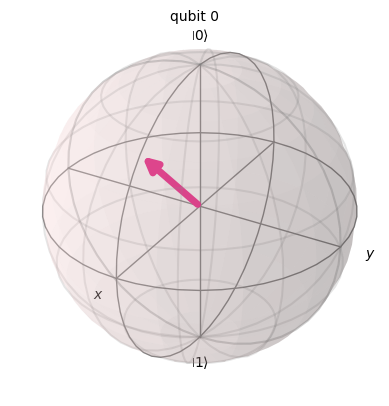

Probability of qubit 0 being in state 0: 0.8535533905932737
Probability of qubit 0 being in state 1: 0.1464466094067262



In [101]:
from IPython.display import display

# Plot Statevector of the first qubit
state = Statevector(qc)
qubit_0_state_0 = state[0] + state[6]
qubit_0_state_1 = state[1] + state[7]
# Renormalize the statevector
norm = np.sqrt(np.abs(qubit_0_state_0) ** 2 + np.abs(qubit_0_state_1) ** 2)
qubit_0_state_0 /= norm
qubit_0_state_1 /= norm
qubit_0_state = Statevector([qubit_0_state_0, qubit_0_state_1])
display(qubit_0_state.draw('latex'))
display(qubit_0_state.draw('bloch'))
print(''.join([f'Probability of qubit 0 being in state {i}: {prob}\n' for i, prob in qubit_0_state.probabilities_dict().items()]))

## Second step
First the qubits 0 and 1 are entangled using CNOT gate, so the state of the system becomes: 
$$\frac{1}{\sqrt{2}}(\alpha\ket{0}(\ket{00} + \ket{11}) + \beta\ket{1}(\ket{10} + \ket{01}))$$

Then a Hadamard gate is applied to qubit 0, so the state of the system becomes:
$$
\begin{align*}
&= \frac{1}{2}(\alpha(\ket{0} + \ket{1})(\ket{00} + \ket{11}) + \beta(\ket{0} - \ket{1})(\ket{10} + \ket{01})) \\
&= \frac{1}{2}(\ket{00}(\alpha\ket{0} + \beta\ket{1}) + \ket{01}(\alpha\ket{1} + \beta\ket{0}) + \ket{10}(\alpha\ket{0} - \beta\ket{1}) + \ket{11}(\alpha\ket{1} - \beta\ket{0}))
\end{align*}
$$
If Alice measures her qubits 0 and 1, there are four possible outcomes: 00, 01, 10, 11. The state of Bob's qubit 2 will be:
- Alice measures 00 $\rightarrow$ Bob's qubit 2 is in state $\alpha\ket{0} + \beta\ket{1}$
- Alice measures 01 $\rightarrow$ Bob's qubit 2 is in state $\alpha\ket{1} + \beta\ket{0}$
- Alice measures 10 $\rightarrow$ Bob's qubit 2 is in state $\alpha\ket{0} - \beta\ket{1}$
- Alice measures 11 $\rightarrow$ Bob's qubit 2 is in state $\alpha\ket{1} - \beta\ket{0}$

So Alice sends the classical bits to Bob and Bob applies the necessary gates to recover the state of qubit 0. The necessary gates are:
- If Qubits 1 is 1, apply X gate to qubit 2
- If Qubits 0 is 1, apply Z gate to qubit 2

In [3]:
# First apply CNOT gate with control qubit 0 and target qubit 1
qc.cx(0, 1)

# Next apply Hadamard gate to qubit 0
qc.h(0)

# Then measure qubit 0 and qubit 1
qc.measure((0, 1), (0, 1))
qc. barrier()

# Apply X gate to qubit 2 if qubit 1 is in state |1> and Z gate if qubit 0 is in state |1>
qc.cx(1, 2)
qc.cz(0, 2)

# Measure qubit 2
qc.measure(2, 2)

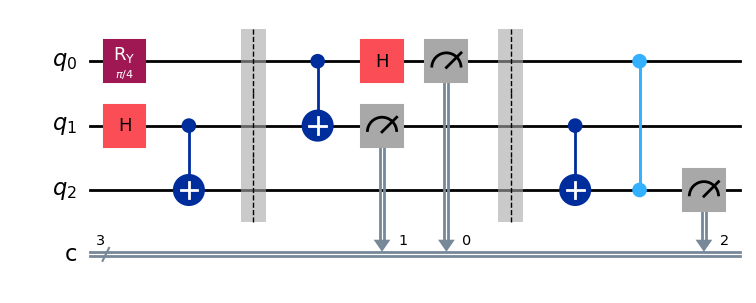

In [4]:
qc.draw(output='mpl')

## Simulation

In [5]:
simulater = AerSimulator()
shots = 4096
sim_result = simulater.run(qc, shots=shots).result()

{'000': 839, '001': 867, '011': 909, '010': 888, '100': 147, '110': 155, '101': 155, '111': 136}


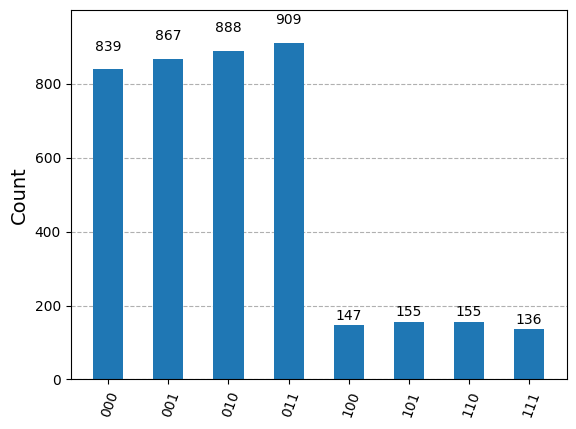

In [6]:
from qiskit.visualization import plot_histogram
print(sim_result.get_counts())
plot_histogram(sim_result.get_counts())

In [103]:
# Results for qubit 2
last_qubit = sum([int(c) for k, c in sim_result.get_counts().items() if k[0] == '1'])
print(f"Probability of qubit 2 being in state |1> is {last_qubit/shots}")
print(f"Probability of qubit 2 being in state |0> is {(shots - last_qubit)/shots}")

Probability of qubit 2 being in state |1> is 0.144775390625
Probability of qubit 2 being in state |0> is 0.855224609375


As we can see, the state of qubit 2 is the same as the state of qubit 0.

## Running the code on a real quantum computer

In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

# Get the backend
backend = service.least_busy(operational=True, simulator=False)

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Transpile the circuit
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(qc)

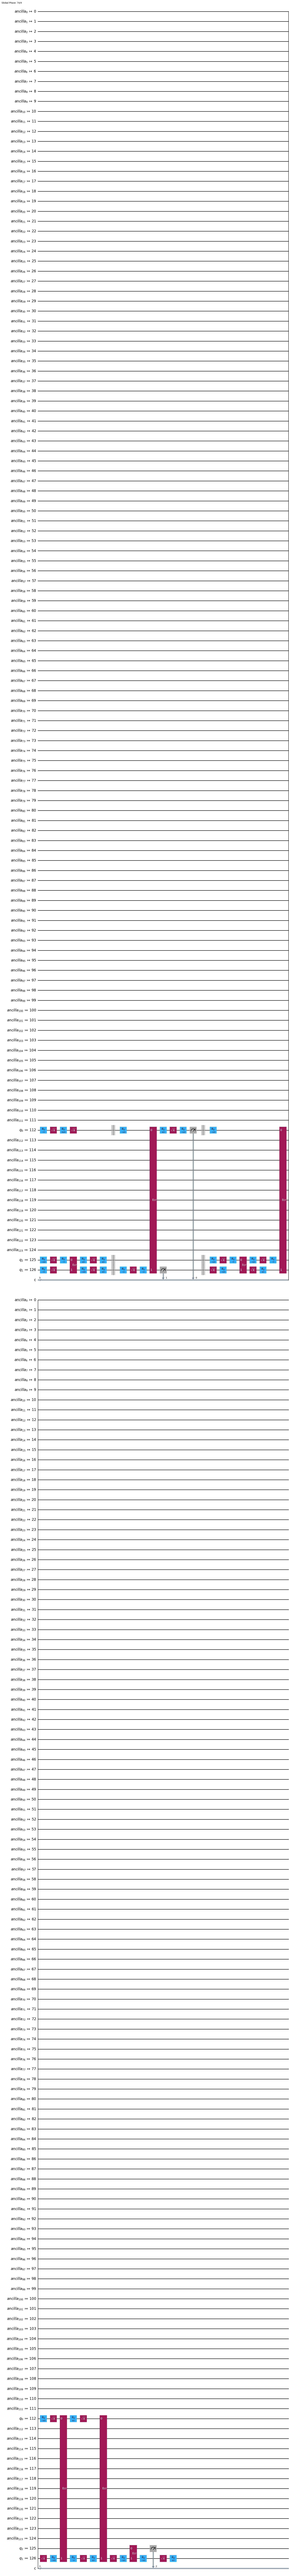

In [10]:
isa_circuit.draw(output='mpl')

In [11]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)

In [13]:
job = sampler.run([isa_circuit])
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cv4fgjahdzz0008m3nz0
>>> Job Status: DONE


In [14]:
result = job.result()

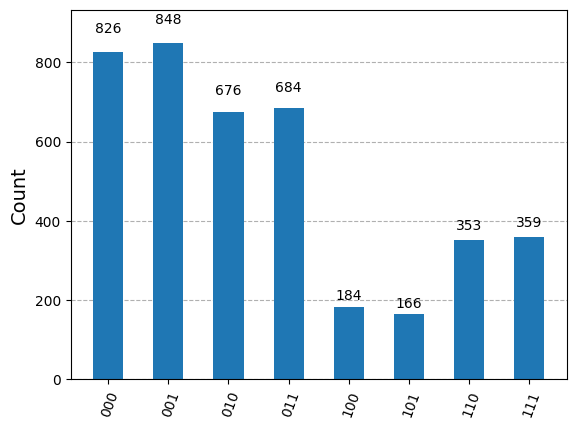

In [15]:
counts = result[0].data.c.get_counts()
plot_histogram(counts)

In [16]:
# Results for qubit 2
shots = result[0].data.c.num_shots
last_qubit = sum([int(c) for k, c in counts.items() if k[0] == '1'])
print(f"Probability of qubit 2 being in state |1> is {last_qubit/shots}")
print(f"Probability of qubit 2 being in state |0> is {(shots - last_qubit)/shots}")

Probability of qubit 2 being in state |1> is 0.25927734375
Probability of qubit 2 being in state |0> is 0.74072265625


## References
1. Nielsen, M. A. & Chuang, I. L. (2010). Quantum Computation and Quantum Information: 10th Anniversary Edition. Cambridge University Press.
2. IBM Quantum Documentation: https://quantum-computing.ibm.com/